In [1]:
import torch
from UnarySim.sw.kernel.mul import UnaryMul
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
rng = "Sobol"

In [9]:
col = 10000
mode = "bipolar"
static = True
bitwidth = 10

if mode is "unipolar":
    input_prob = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
elif mode is "bipolar":
    input_prob = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

# print(input_prob)
# print(iVec)
# print(oVec)


dut_mul = UnaryMul(bitwidth,mode,static,input_prob).to(device)

# if mode is "unipolar":
iVec = torch.rand(col).mul(2**bitwidth).round().div(2**bitwidth).to(device)
# elif mode is "bipolar":
#     iVec = torch.rand(col).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)

# oVec = torch.mul(iVec, input_prob).mul(2).sub(1).mul(2**bitwidth).round().div(2**bitwidth).to(device)
oVec = torch.mul(iVec, input_prob).mul(2**bitwidth).round().div(2**bitwidth).to(device)



iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

iVecSource = SourceGen(iVec, bitwidth, mode=mode)().to(device)
iVecRNG = RNG(bitwidth, 1, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

with torch.no_grad():
    start_time = time.time()
    for i in range(2**bitwidth):
        #print(i)
        iBS = iVecBS(i)
        iVecPE.Monitor(iBS)
        oVecU = dut_mul(iBS)   
        oVecPE.Monitor(oVecU)
#         print(iBS)
#         print(oVecU)
    print("--- %s seconds ---" % (time.time() - start_time))
    print("input error: ", torch.min(iVecPE()[1]), torch.max(iVecPE()[1]))
    print("output error: ", torch.min(oVecPE()[1]), torch.max(oVecPE()[1]))
    result_pe = oVecPE()[1].cpu().numpy()
    print(result_pe)

--- 0.8969993591308594 seconds ---
input error:  tensor(-0.0010, device='cuda:0') tensor(0.0010, device='cuda:0')
output error:  tensor(-0.0078, device='cuda:0') tensor(0.0059, device='cuda:0')
[ 0.         -0.00292969  0.00195312 ...  0.00097656  0.
 -0.00195312]


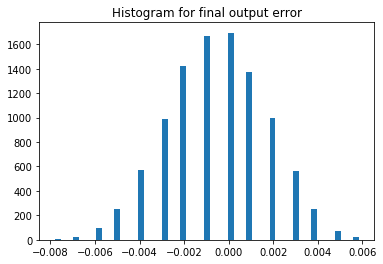

In [10]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

